# Previsão do Índice Ibovespa utilizando Modelos de Machine Learning e Séries Temporais
O Índice Bovespa (Ibovespa) é o principal indicador do desempenho das ações negociadas na B3 (Bolsa de Valores do Brasil). Ele reflete a média ponderada das cotações dos ativos mais negociados e, por isso, desempenha um papel crucial nas decisões de investimentos. Dada a volatilidade e complexidade do mercado financeiro, a previsão de seu comportamento futuro pode proporcionar grandes vantagens competitivas para investidores e gestores de portfólio. Este projeto tem como objetivo prever o comportamento do Ibovespa usando algoritmos de machine learning e técnicas avançadas de séries temporais.

# Bibliotecas

In [73]:
!pip install xgboost
!pip install pmdarima
!pip install prophet 

# Metodologia
Para abordar este problema, utilizamos diferentes modelos de previsão, incluindo XGBoost, Prophet e SARIMAX. Essas bibliotecas foram escolhidas por sua capacidade de lidar com grandes volumes de dados e capturar padrões complexos, como tendências e sazonalidades.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
import pmdarima as pm
from prophet import Prophet
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error

)
from statsmodels.tsa.seasonal import seasonal_decompose

# Coleta dos Dados
A coleta dos dados foi realizada a partir de arquivos históricos, com informações que cobrem o período de 2000 a 2024. O uso desses dados possibilitará a aplicação de técnicas de modelagem robustas e eficientes.

- Data: Data dos registros
- Último: ùltimo preço registrado no dia
- Abertura: Preço inicial do dia
- Máxima: Preço máximo do dia
- Mínima: Preço mínimo do dia
- Vol.: Volume de negociação do dia
- Var%: Variação do dia (Abertura/Último)ltimo)ltimo)

In [2]:
df1 = pd.read_csv("C:\\Users\\evert\\TechChalenger2/Dados/Ibovespa_00_a_14.csv", decimal=",", thousands=".")
df2 = pd.read_csv("C:\\Users\\evert\\TechChalenger2/Dados/Ibovespa_15_a_24.csv", decimal=",", thousands=".")

In [3]:
df1.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,30122014,50007,50601,50841,49993,"2,93M","-1,16%"
1,29122014,50594,50145,50903,50008,"1,85M","0,90%"
2,26122014,50145,50891,50973,49914,"1,91M","-1,46%"
3,23122014,50890,50121,50890,49815,"2,67M","1,53%"
4,22122014,50121,49651,50121,49105,"2,68M","0,95%"


In [4]:
df2.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,10102024,130353,129963,130418,129835,"7,62B","0,30%"
1,9102024,129962,131510,131520,129719,"9,22B","-1,18%"
2,8102024,131512,132016,132016,130371,"9,09B","-0,38%"
3,7102024,132018,131792,132943,131676,"7,70B","0,17%"
4,4102024,131792,131672,131936,131156,"7,05B","0,09%"


In [5]:
df_ibov = pd.concat([df1, df2], ignore_index=True)
df_ibov

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,30122014,50007,50601,50841,49993,"2,93M","-1,16%"
1,29122014,50594,50145,50903,50008,"1,85M","0,90%"
2,26122014,50145,50891,50973,49914,"1,91M","-1,46%"
3,23122014,50890,50121,50890,49815,"2,67M","1,53%"
4,22122014,50121,49651,50121,49105,"2,68M","0,95%"
...,...,...,...,...,...,...,...
6137,8012015,49943,49463,50261,49017,"3,62M","0,97%"
6138,7012015,49463,48006,49882,48006,"4,41M","3,05%"
6139,6012015,48001,47517,48061,47338,"4,56M","1,02%"
6140,5012015,47517,48512,48512,47264,"3,87M","-2,05%"


In [6]:
def correcao_data(data):
    data_str = str(data)
    if len(data_str) == 7:
        return "0" + data_str
    return data_str

df_ibov["Data"] = df_ibov["Data"].apply(correcao_data)

df_ibov["Data"] = pd.to_datetime(df_ibov["Data"], format="%d%m%Y")

df_ibov = df_ibov.sort_values(by="Data", ascending=True, ignore_index=True)

df_ibov

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2000-01-03,16930,17098,17408,16719,"777,29M","-0,95%"
1,2000-01-04,15851,16908,16908,15851,"102,42M","-6,37%"
2,2000-01-05,16245,15871,16302,15350,"112,10M","2,49%"
3,2000-01-06,16107,16237,16499,15977,"105,25M","-0,85%"
4,2000-01-07,16309,16125,16449,16125,"633,18M","1,25%"
...,...,...,...,...,...,...,...
6137,2024-10-04,131792,131672,131936,131156,"7,05B","0,09%"
6138,2024-10-07,132018,131792,132943,131676,"7,70B","0,17%"
6139,2024-10-08,131512,132016,132016,130371,"9,09B","-0,38%"
6140,2024-10-09,129962,131510,131520,129719,"9,22B","-1,18%"


In [7]:
df_ibov = df_ibov[["Data", "Último", "Abertura"]]

df_ibov.dtypes

Data        datetime64[ns]
Último               int64
Abertura             int64
dtype: object

In [8]:
df_ibov.isnull().sum()

Data        0
Último      0
Abertura    0
dtype: int64

In [9]:
df_ibov.duplicated().sum()

0

# Exploração de Dados

Os dados serão explorados inicialmente para identificar tendências e sazonalidades presentes ao longo dos anos. A análise poderá revelar a existência de comportamentos cíclicos e possíveis períodos de alta e baixa correlacionados. Foram gerados gráficos exploratórios que demonstraram a variação do índice ao longo do tempo, além da decomposição dos componentes de tendência e sazonalidade, o que serviu de base para a construção dos modelos preditivos.

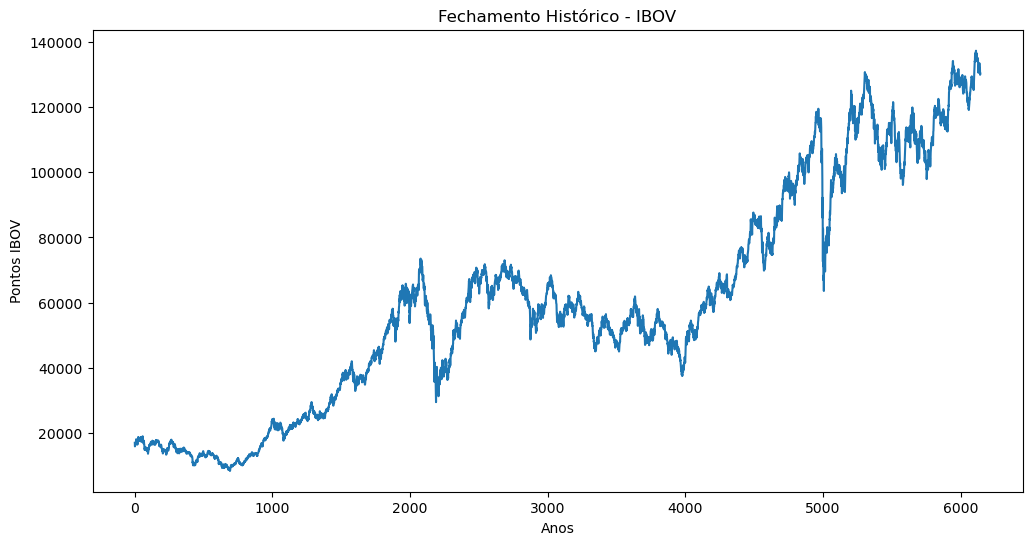

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df_ibov.index, df_ibov['Último'], label='Preço de Fechamento')
plt.ylabel('Pontos IBOV')
plt.xlabel('Anos')
plt.title('Fechamento Histórico - IBOV')

plt.show()

In [11]:
result = seasonal_decompose(df_ibov['Último'], model='multiplicative', period=365)

<Axes: >

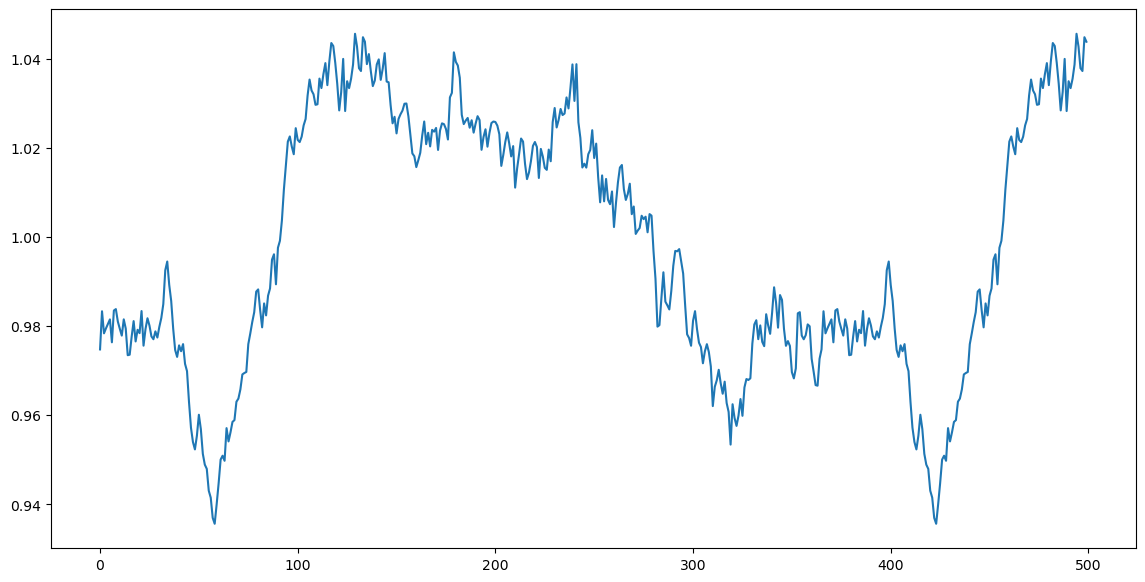

In [12]:
result.seasonal.iloc[:500].plot(figsize=(14,7))

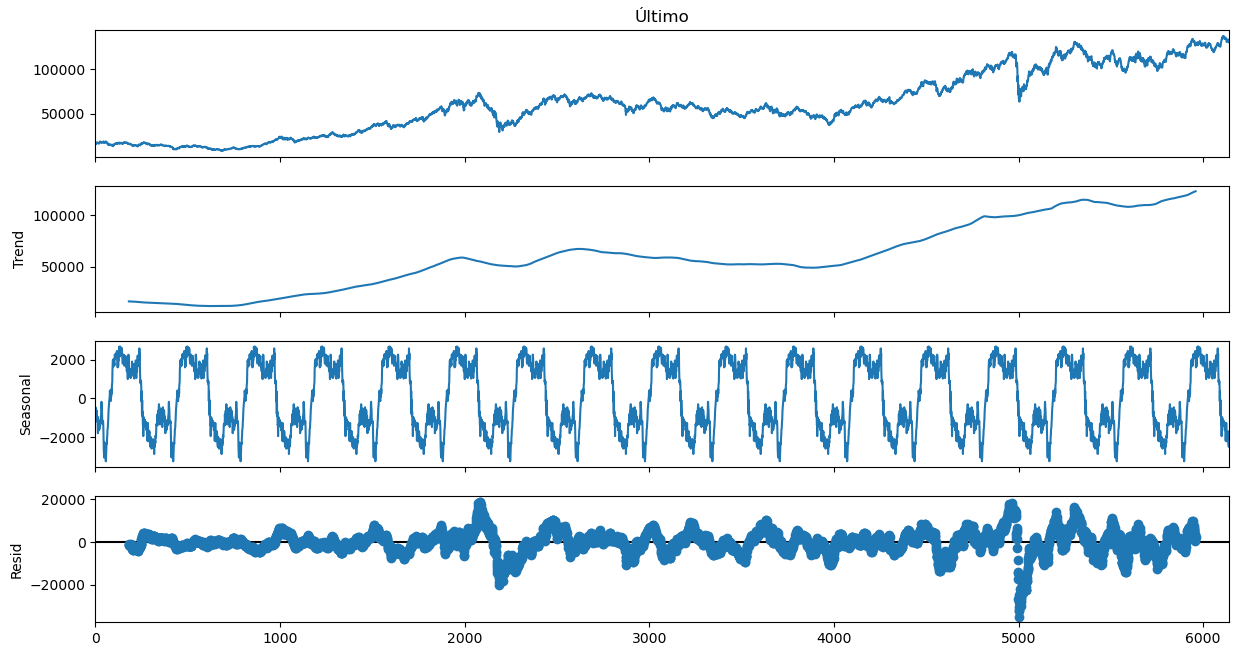

In [13]:
result = seasonal_decompose(df_ibov['Último'], model='additive', period=365)
fig = result.plot()
fig.set_size_inches(14,7)

# Estacionariedade

In [14]:
adf_result = sm.tsa.adfuller(df_ibov['Último'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.03:
  print("A série temporal é estacionária")
else:
  print("A série temporal não é estacionária")

ADF Statistic: -0.6839470858971154
p-value: 0.8508639032664944
Critical Values: {'1%': -3.43141721703914, '5%': -2.8620116136650924, '10%': -2.5670210372329807}
A série temporal não é estacionária


C:\Users\evert\AppData\Local\Temp\ipykernel_9916\2703323039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ibov.loc[:, 'Diferenciado'] = df_ibov['Último'].diff()


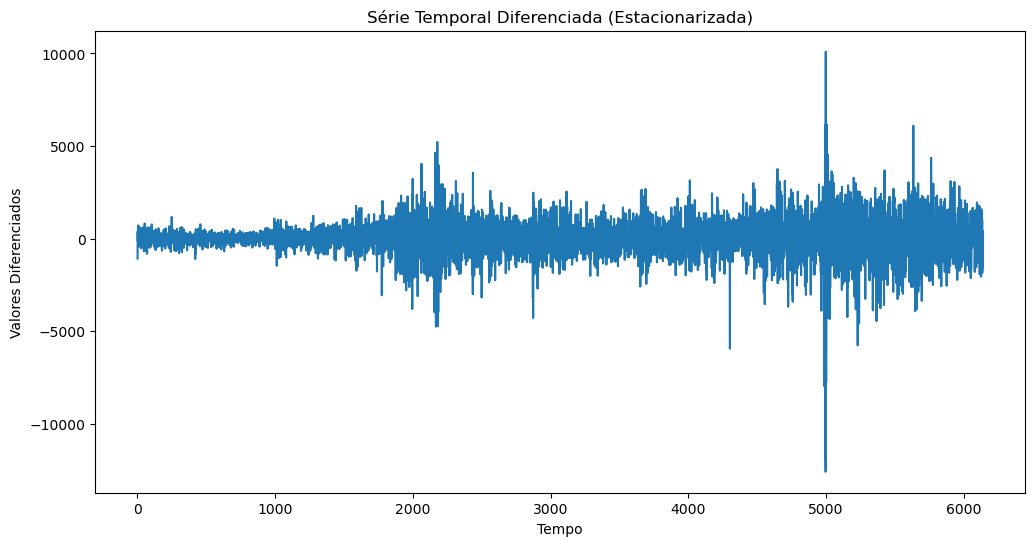

In [15]:
df_ibov.loc[:, 'Diferenciado'] = df_ibov['Último'].diff()

plt.figure(figsize=(12, 6))
plt.plot(df_ibov['Diferenciado'])
plt.title('Série Temporal Diferenciada (Estacionarizada)')
plt.xlabel('Tempo')
plt.ylabel('Valores Diferenciados')
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_ibov['Diferenciado'].dropna())

print(f"Valor-p: {result[1]}")

if result[1] < 0.05:
    print("A série diferenciada é estacionária (Rejeitamos H0).")
else:
    print("A série diferenciada ainda não é estacionária (Não rejeitamos H0).")

Valor-p: 0.0
A série diferenciada é estacionária (Rejeitamos H0).


In [17]:
from statsmodels.graphics.tsaplots import plot_acf as _plot_acf

<Figure size 1200x600 with 0 Axes>

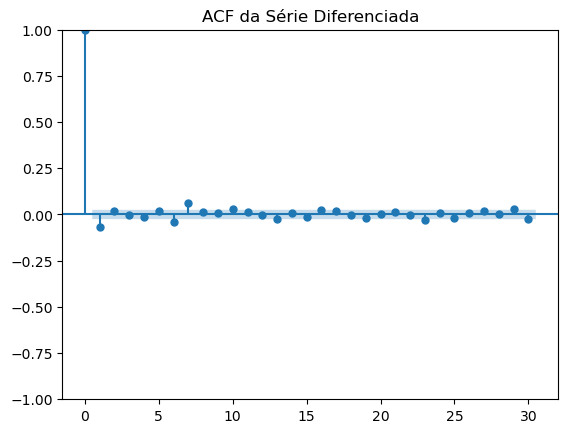

In [18]:
plt.figure(figsize=(12, 6))
_plot_acf(df_ibov['Diferenciado'].dropna(), lags=30)
plt.title('ACF da Série Diferenciada')
plt.show()

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf as _plot_pacf

<Figure size 1200x600 with 0 Axes>

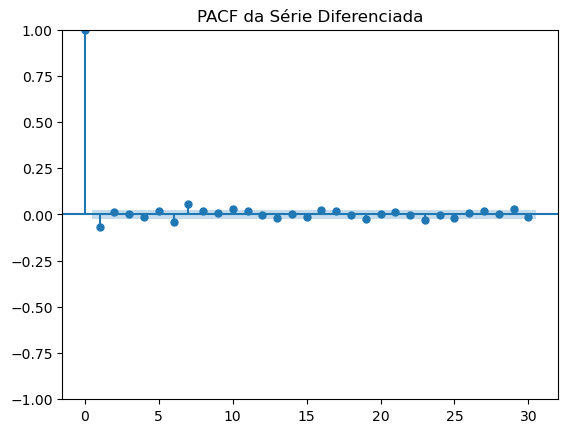

In [20]:
plt.figure(figsize=(12, 6))
_plot_pacf(df_ibov['Diferenciado'].dropna(), lags=30)
plt.title('PACF da Série Diferenciada')
plt.show()

# Divisão de treino e teste

Para a aplicação dos modelos, a divisão de Treino e Teste foi definido da seguinte forma:
- Treino: Foi definido o período de 2000 a 2023;
- Teste: Para teste foi definido o período de 2024 (mês 01 até mês 10)

In [22]:
train_size = len(df_ibov) - 198
train, test = df_ibov[:train_size], df_ibov[train_size:]


def create_features(df_f):
  df_f = df_f.reset_index()
  df_f["Data"] = pd.to_datetime(df_f["Data"])
  df_f["year"] = df_f["Data"].dt.year
  df_f['month'] = df_f["Data"].dt.month
  df_f["day"] = df_f["Data"].dt.day
  df_f["dayofweek"] = df_f["Data"].dt.dayofweek
  return df_f

train = create_features(train)
test = create_features(test)

FEATURES =["year", "month", "day", "dayofweek", "Abertura"]
TARGET = "Último"

# Modelagem
- XGBoost: Modelo baseado em árvores de decisão, que se destacou por sua flexibilidade em lidar com grandes quantidades de dados e por capturar interações complexas.
- Prophet: Especializado em capturar padrões de sazonalidade e tendências de longo prazo, o Prophet demonstrou excelente desempenho na previsão de séries temporais com múltiplas sazonalidades.
- SARIMAX: Modelo clássico para séries temporais, capaz de incorporar fatores exógenos e capturar componentes sazonais. Ele foi utilizado para prever as oscilações do Ibovespa com base nos dados históricos.

# Modelo XGBoost

In [66]:
x_train, y_train = train[FEATURES], train[TARGET]
x_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective = "reg:squarederror")
reg.fit(x_train, y_train)

preds_xgb = reg.predict(x_test)

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {"MSE": mse, "MAE": mae, "MAPE": mape}

metrics_xgb = calculate_metrics(y_test, preds_xgb)
MAPE_xgb = metrics_xgb["MAPE"]
print("XGBoost Metrics:")
print(metrics_xgb)
print(f"Acurácia de {100 - (MAPE_xgb * 100): .2f}%")

XGBoost Metrics:
{'MSE': 18587153.690938007, 'MAE': 3399.561119002525, 'MAPE': 0.025965987857915762}
Acurácia de  97.40%


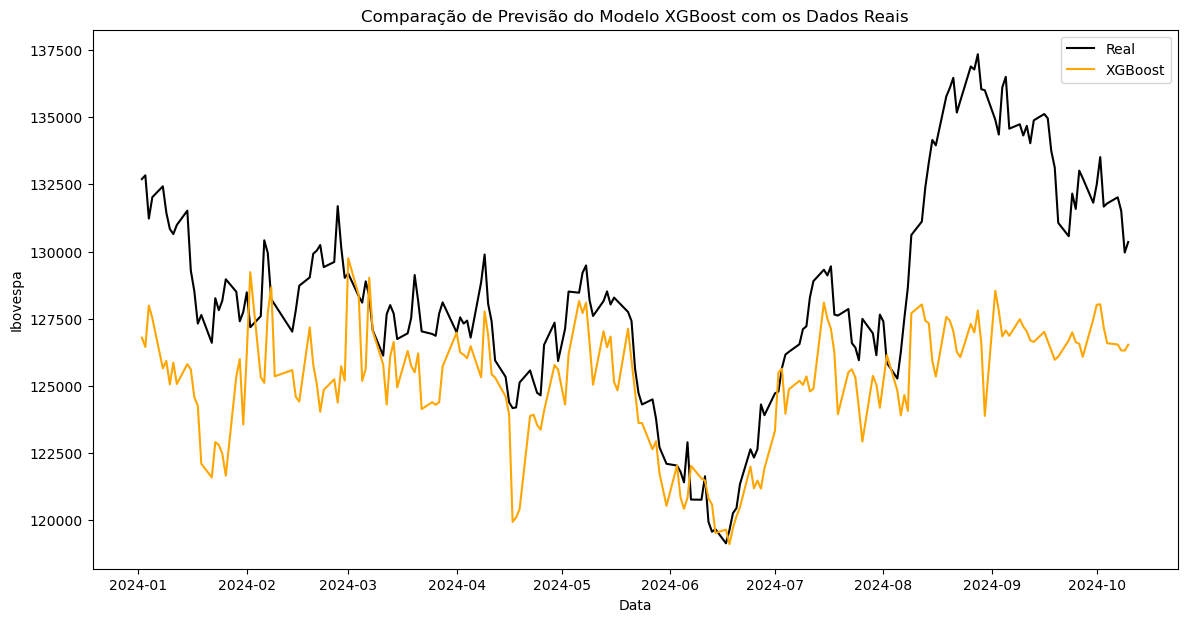

In [69]:
xgboost_results = pd.DataFrame({'Data': test['Data'], 'Previsão': preds_xgb})

plt.figure(figsize=(14, 7))

plt.plot(test['Data'], test['Último'], label='Real', color='black')

plt.plot(xgboost_results['Data'], xgboost_results['Previsão'], label='XGBoost', color='orange')

plt.title('Comparação de Previsão do Modelo XGBoost com os Dados Reais')
plt.xlabel('Data')
plt.ylabel('Ibovespa')
plt.legend()
plt.show()

# Modelo Prophet

In [67]:
train_prophet = train.rename(columns={"Data": "ds", "Último": "y"})
test_prophet = test.rename(columns={"Data": "ds", "Último": "y"})

model = Prophet(daily_seasonality=True)
model.add_regressor("Abertura")
model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test))
future["Abertura"] = pd.concat([train["Abertura"], test["Abertura"]], ignore_index=True)
forecast = model.predict(future)

preds_pr = forecast[["ds", "yhat"]].tail(len(test))
preds_pr = preds_pr.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]

metrics_pr = calculate_metrics(y_test, preds_pr["yhat"])
MAPE_pr = metrics_pr["MAPE"]
print("Prophet Metrics")
print(metrics_pr)
print(f"Acurácia de {100 - (MAPE_pr * 100): .2f}%")

08:15:59 - cmdstanpy - INFO - Chain [1] start processing
08:16:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet Metrics
{'MSE': 9223125.812847333, 'MAE': 2148.5162733419097, 'MAPE': 0.016750113807786824}
Acurácia de  98.32%


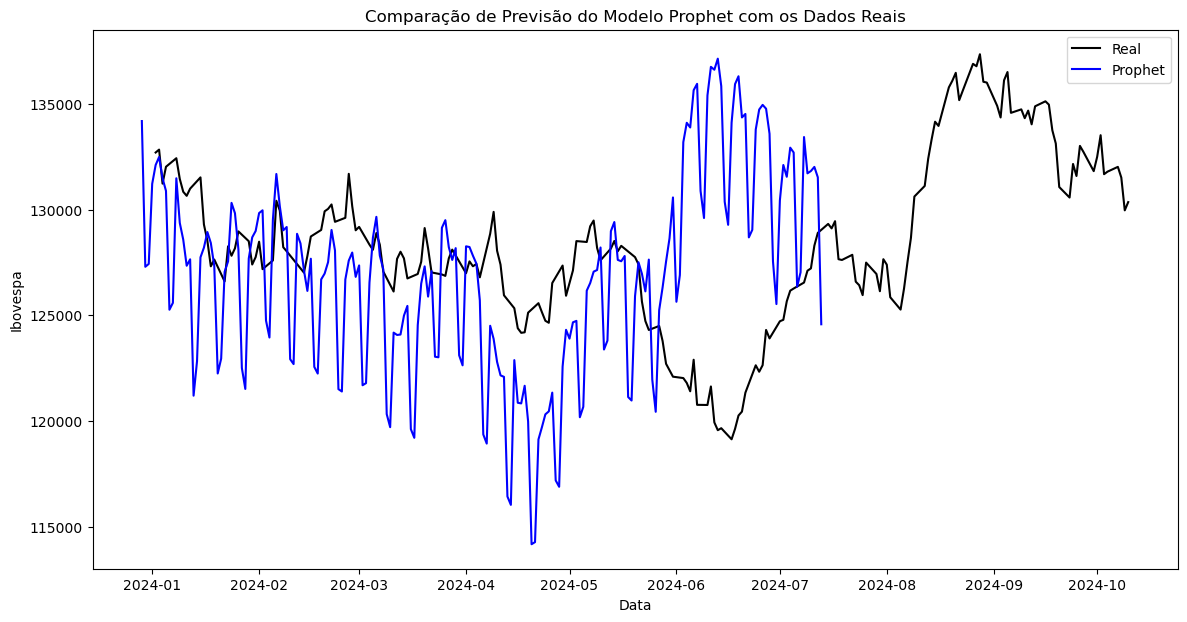

In [70]:
prophet_results = preds_pr.reset_index()

plt.figure(figsize=(14, 7))

plt.plot(test['Data'], test['Último'], label='Real', color='black')

plt.plot(prophet_results['ds'], prophet_results['yhat'], label='Prophet', color='blue')

plt.title('Comparação de Previsão do Modelo Prophet com os Dados Reais')
plt.xlabel('Data')
plt.ylabel('Ibovespa')
plt.legend()
plt.show()

# Seleção de parâmetros para modelos SARIMAX

In [21]:
model = pm.auto_arima(
    df_ibov['Último'].dropna(),
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True
)

print(model.summary())

seasonal_order = model.seasonal_order
print(f"Detected Seasonal Order: {seasonal_order}")

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6141
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -51192.557
Date:                Mon, 14 Oct 2024   AIC                         102395.114
Time:                        07:20:45   BIC                         102428.727
Sample:                             0   HQIC                        102406.773
                               - 6141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5165      0.034    -44.458      0.000      -1.583      -1.450
ar.L2         -0.7190      0.035    -20.674      0.000      -0.787      -0.651
ma.L1          1.4586      0.036     39.998      0.0

# Modelo SARIMAX

In [68]:
exog_train = train[["Abertura"]]
exog_test = test[["Abertura"]]

model = sm.tsa.statespace.SARIMAX(
    train["Último"],
    exog=exog_train,
    order=(
        2,
        1,
        2,
    ),
    seasonal_order=(0, 0, 0, 12),
)
result = model.fit()

preds_sarimax = result.get_forecast(steps=len(test), exog=exog_test).predicted_mean

metrics_sarimax = calculate_metrics(test["Último"], preds_sarimax)
MAPE_sarimax = metrics_sarimax["MAPE"]
print("SARIMAX Metrics")
print(metrics_sarimax)
print(f"Acurácia de {100 - (MAPE_sarimax * 100): .2f}%")

SARIMAX Metrics
{'MSE': 59286946.8260725, 'MAE': 6672.094724630531, 'MAPE': 0.05289128075519974}
Acurácia de  94.71%


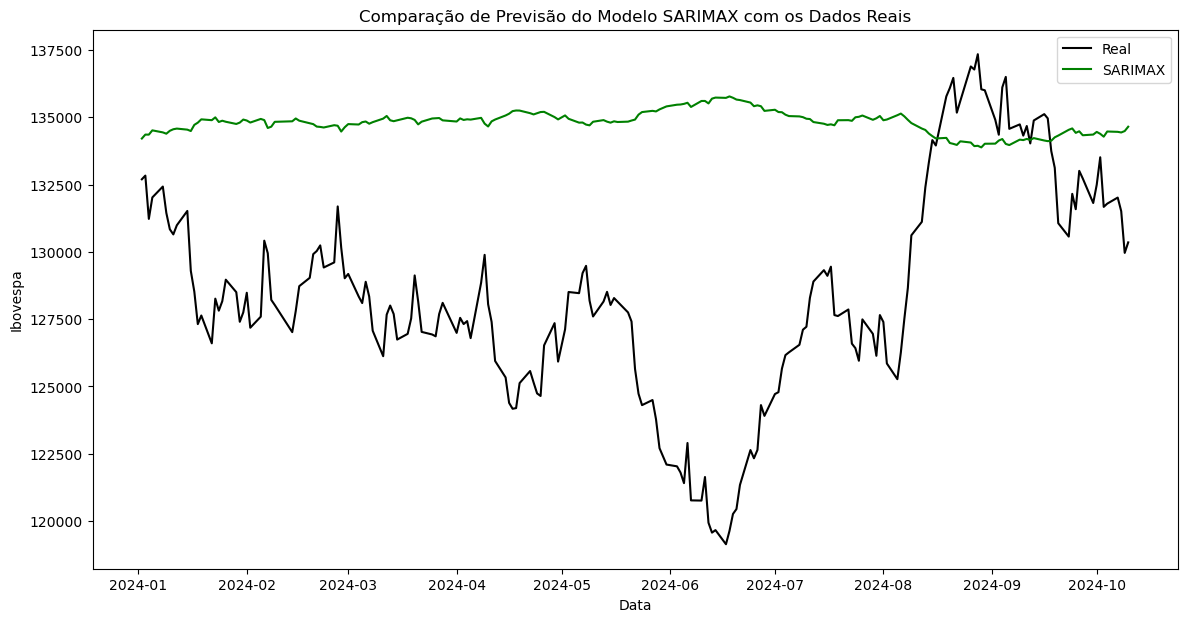

In [71]:
sarimax_results = pd.DataFrame({
    'Data': pd.to_datetime(test['Data']),
    'Previsão': preds_sarimax.values
})

plt.figure(figsize=(14, 7))

plt.plot(test['Data'], test['Último'], label='Real', color='black')

plt.plot(sarimax_results['Data'], sarimax_results['Previsão'], label='SARIMAX', color='green')

plt.title('Comparação de Previsão do Modelo SARIMAX com os Dados Reais')
plt.xlabel('Data')
plt.ylabel('Ibovespa')
plt.legend()
plt.show()

# Comparando os modelos

In [29]:
df_modelos = pd.DataFrame(
    [metrics_xgb, metrics_pr, metrics_sarimax],
    columns=["MAE", "MSE", "MAPE"],
    index=["XGBoost", "Prophet", "SARIMAX"],
)

df_modelos["Acurácia%"] = (100 - (df_modelos["MAPE"] * 100)).map('{:,.2f}'.format)

df_modelos.sort_values(by="Acurácia%", ascending=False)

,MAE,MSE,MAPE,Acurácia%
Prophet,2148.516273,9.223126e+06,0.016750,98.32
XGBoost,3399.561119,1.858715e+07,0.025966,97.40
SARIMAX,6672.094725,5.928695e+07,0.052891,94.71


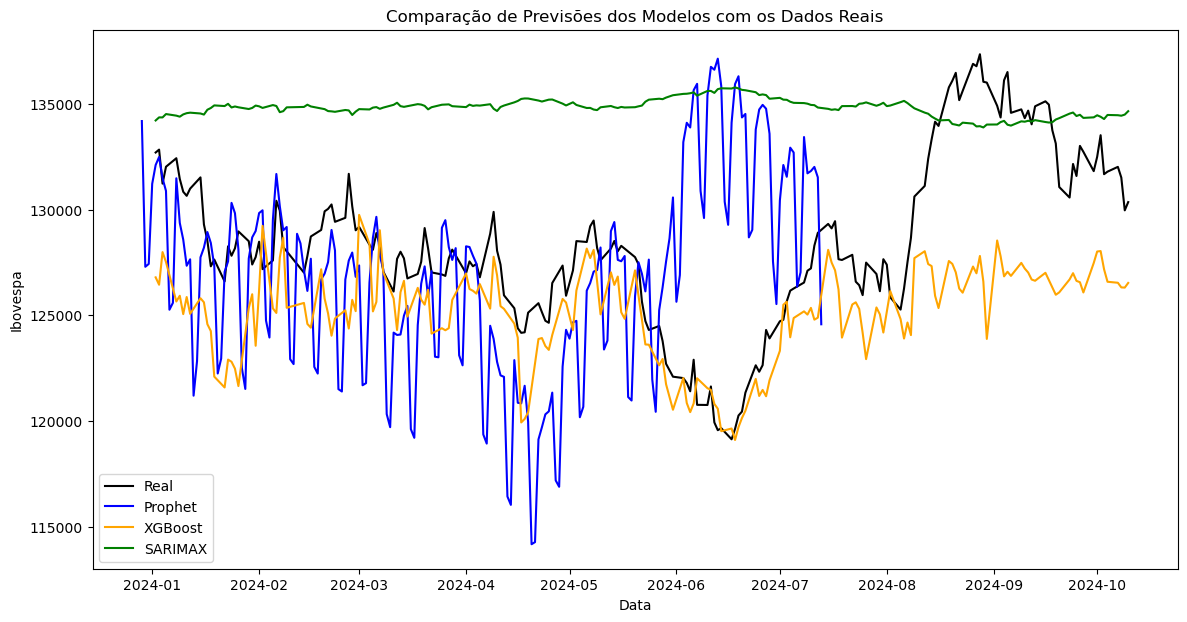

In [73]:
plt.figure(figsize=(14, 7))

plt.plot(test['Data'], test['Último'], label='Real', color='black')

plt.plot(prophet_results['ds'], prophet_results['yhat'], label='Prophet', color='blue')

plt.plot(xgboost_results['Data'], xgboost_results['Previsão'], label='XGBoost', color='orange')

plt.plot(sarimax_results['Data'], sarimax_results['Previsão'], label='SARIMAX', color='green')

plt.title('Comparação de Previsões dos Modelos com os Dados Reais')
plt.xlabel('Data')
plt.ylabel('Ibovespa')
plt.legend()
plt.show()

# Observações do Gráfico:
- Prophet (linha azul):

As previsões do Prophet estão oscilando significativamente, com picos e vales muito acentuados. Pode ser um sinal de que o modelo não está capturando bem o comportamento real do Ibovespa ou que a sazonalidade está sendo superestimada.

- XGBoost (linha laranja):

O modelo XGBoost parece mais estável, mas com previsões mais "achatadas", indicando que ele não está capturando as variações mais extremas dos dados reais. Isso pode sugerir uma menor variância nas previsões.

- SARIMAX (linha verde):

O SARIMAX se desvia consideravelmente dos dados reais, especialmente em várias partes do gráfico. Essa discrepância se traduz nas piores métricas entre os modelos.

- Dados Reais (linha preta):

A linha dos dados reais apresenta as oscilações esperadas do Ibovespa, e a comparação com os modelos mostra que nenhum deles está capturando perfeitamente todas as flutuações.

# Resultados
As previsões geradas pelos modelos foram comparadas com os dados reais, permitindo uma avaliação rigorosa do desempenho dos algoritmos. O modelo Prophet apresentou o melhor desempenho, com um erro percentual (MAPE) de apenas 2% e uma acurácia de 98,32%. Em seguida, o XGBoost teve uma acurácia de 97,40% e o SARIMAX, de 94,71%. Apesar de o SARIMAX capturar adequadamente componentes sazonais, sua performance foi inferior aos outros modelos, especialmente em termos de MSE e MAE.

# Conclusão
A capacidade de prever o comportamento futuro do Ibovespa pode trazer grandes benefícios para investidores e gestores de ativos, fornecendo uma ferramenta valiosa para mitigar riscos e identificar oportunidades de investimento. Este estudo mostrou que modelos como XGBoost e Prophet são eficazes para essa tarefa, capturando tanto tendências de longo prazo quanto oscilações de curto prazo. O modelo SARIMAX, embora robusto, apresentou desempenho inferior. Como próximos passos, o refinamento dos modelos com dados adicionais e a inclusão de variáveis macroeconômicas podem aprimorar ainda mais a acurácia das previsões.